In [1]:
import numpy as np
import tensorflow as tf
import pathlib2 as pl
import os

2022-12-10 07:06:41.714926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 07:06:42.015606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 07:06:42.015649: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-10 07:06:43.972556: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
img_dir = '/home/mkb/Downloads/AI-COURSEWORK/animals/animals'
data_dir = pl.Path(img_dir)
animal_files = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(img_dir)
    for f in files if f.endswith('.jpg')]
image_count = len(list(data_dir.glob('*/*.jpg')))

In [3]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

2022-12-10 07:07:03.670671: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-10 07:07:03.670714: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-10 07:07:03.670736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MadMax): /proc/driver/nvidia/version does not exist
2022-12-10 07:07:03.673033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/mkb/Downloads/AI-COURSEWORK/animals/animals/hummingbird/76dd09d47a.jpg'
b'/home/mkb/Downloads/AI-COURSEWORK/animals/animals/fox/49dad2f338.jpg'
b'/home/mkb/Downloads/AI-COURSEWORK/animals/animals/squid/16c1efde43.jpg'
b'/home/mkb/Downloads/AI-COURSEWORK/animals/animals/deer/5c3ecf6b76.jpg'
b'/home/mkb/Downloads/AI-COURSEWORK/animals/animals/donkey/400c63b9e5.jpg'


In [10]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
print(class_names.size)

['antelope' 'badger' 'bat' 'bear' 'bee' 'beetle' 'bison' 'boar'
 'butterfly' 'cat' 'caterpillar' 'chimpanzee' 'cockroach' 'cow' 'coyote'
 'crab' 'crow' 'deer' 'dog' 'dolphin' 'donkey' 'dragonfly' 'duck' 'eagle'
 'elephant' 'flamingo' 'fly' 'fox' 'goat' 'goldfish' 'goose' 'gorilla'
 'grasshopper' 'hamster' 'hare' 'hedgehog' 'hippopotamus' 'hornbill'
 'horse' 'hummingbird' 'hyena' 'jellyfish' 'kangaroo' 'koala' 'ladybugs'
 'leopard' 'lion' 'lizard' 'lobster' 'mosquito' 'moth' 'mouse' 'octopus'
 'okapi' 'orangutan' 'otter' 'owl' 'ox' 'oyster' 'panda' 'parrot'
 'pelecaniformes' 'penguin' 'pig' 'pigeon' 'porcupine' 'possum' 'raccoon'
 'rat' 'reindeer' 'rhinoceros' 'sandpiper' 'seahorse' 'seal' 'shark'
 'sheep' 'snake' 'sparrow' 'squid' 'squirrel' 'starfish' 'swan' 'tiger'
 'turkey' 'turtle' 'whale' 'wolf' 'wombat' 'woodpecker' 'zebra']
90


In [11]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

SPLITTING THE DATASET

In [12]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
val_ds_card = tf.data.experimental.cardinality(val_ds).numpy()

4320
1080


In [18]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [17]:
def decode_img(img):

  img_height = 180
  img_width = 180
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [15]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  69


In [21]:
batch_size = 32
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

CHECKING OUR DATASETS

2022-12-10 05:40:02.869026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


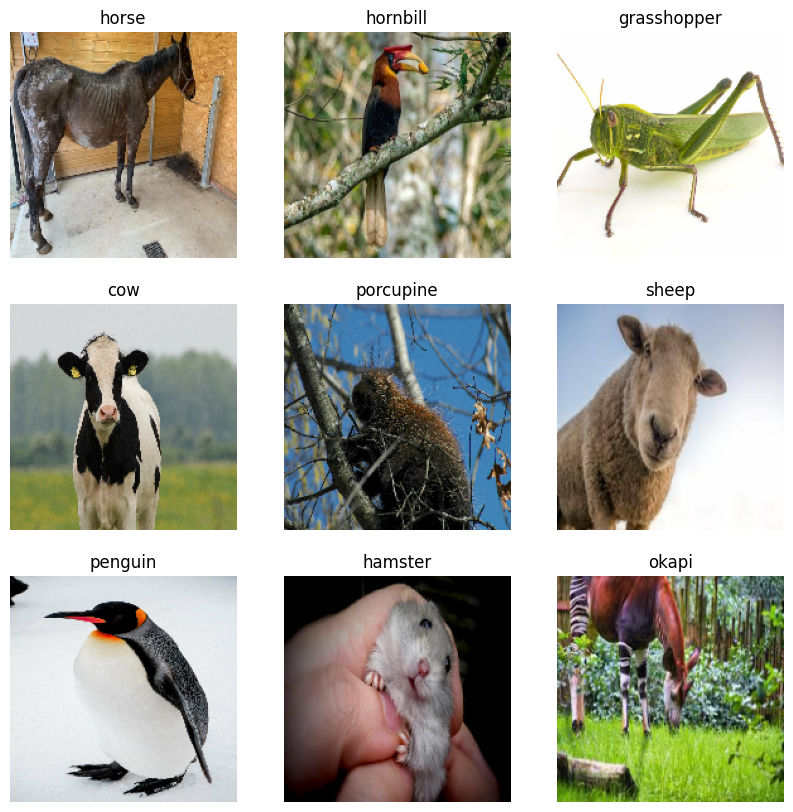

In [23]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

MAKING THE MODEL

In [25]:
num_classes = 90
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
history= model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
135/135 [==============================] - 282s 2s/step - loss: 4.4487 - accuracy: 0.0211 - val_loss: 4.4029 - val_accuracy: 0.0296
Epoch 2/3
135/135 [==============================] - 240s 2s/step - loss: 4.2327 - accuracy: 0.0532 - val_loss: 4.1486 - val_accuracy: 0.0611
Epoch 3/3
135/135 [==============================] - 233s 2s/step - loss: 3.6454 - accuracy: 0.1521 - val_loss: 3.8019 - val_accuracy: 0.1343


In [29]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 32)       

EVALUATION

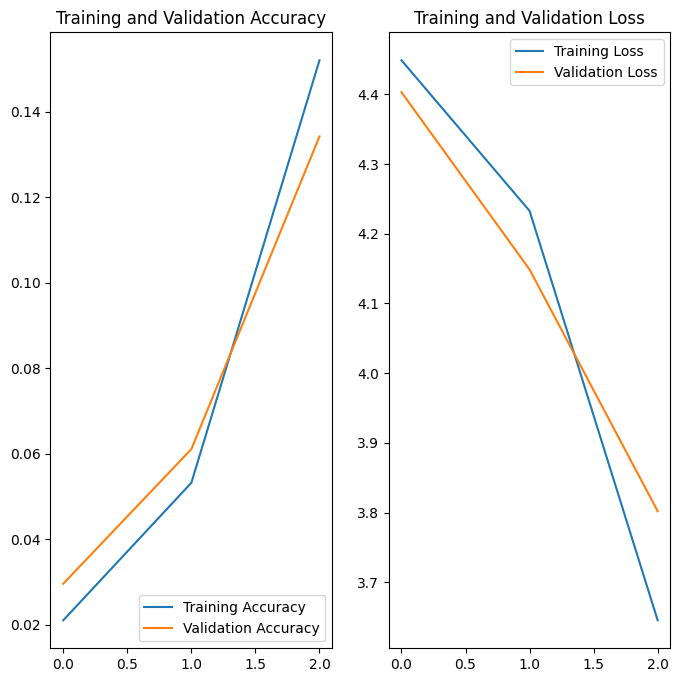

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


HYPERTUNING

In [28]:
import keras_tuner as kt
tuner = kt.BayesianOptimization(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, label_batch, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

TypeError: Tuner.__init__() got an unexpected keyword argument 'max_epochs'